In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

2024-06-27 10:35:17.455715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Importing plotly failed. Interactive plots will not work.


In [82]:

# Load the preprocessed weekly data
file_path = '../data/weekly_data_train.csv'
train_data = pd.read_csv(file_path, parse_dates=['Timestamp'])

file_path = '../data/weekly_data_test.csv'
test_data = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Ensure 'Timestamp' is a DateTime type
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'])

# Set the 'Timestamp' column as the index
train_data.set_index('Timestamp', inplace=True)
test_data.set_index('Timestamp', inplace=True)

# Extract week of year and year from the index
train_data['WeekOfYear'] = train_data.index.isocalendar().week
train_data['Year'] = train_data.index.year

test_data['WeekOfYear'] = test_data.index.isocalendar().week
test_data['Year'] = test_data.index.year

print('Data loading complete..')

Data loading complete..


Training and test data loaded...


/Users/ishwarpawar/opt/anaconda3/envs/test_ml/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/ishwarpawar/opt/anaconda3/envs/test_ml/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
14:02:00 - cmdstanpy - INFO - Chain [1] start processing


SARIMA execution complete...


14:02:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet execution complete...
Random Forest execution complete...
Gradient Boosting execution complete...
LSTM execution complete...
trainX shape: (912, 1)
trainY shape: (912,)
testX shape: (1520, 1)
testY shape: (1520,)
Reshaped trainX shape: (912, 1, 1)
Reshaped testX shape: (1520, 1, 1)
Epoch 1/100
912/912 - 4s - loss: 0.0256 - 4s/epoch - 4ms/step
Epoch 2/100
912/912 - 2s - loss: 0.0189 - 2s/epoch - 2ms/step
Epoch 3/100
912/912 - 2s - loss: 0.0188 - 2s/epoch - 2ms/step
Epoch 4/100
912/912 - 2s - loss: 0.0189 - 2s/epoch - 2ms/step
Epoch 5/100
912/912 - 2s - loss: 0.0189 - 2s/epoch - 2ms/step
Epoch 6/100
912/912 - 3s - loss: 0.0190 - 3s/epoch - 3ms/step
Epoch 7/100
912/912 - 2s - loss: 0.0190 - 2s/epoch - 2ms/step
Epoch 8/100
912/912 - 2s - loss: 0.0187 - 2s/epoch - 2ms/step
Epoch 9/100
912/912 - 2s - loss: 0.0188 - 2s/epoch - 2ms/step
Epoch 10/100
912/912 - 2s - loss: 0.0187 - 2s/epoch - 3ms/step
Epoch 11/100
912/912 - 2s - loss: 0.0187 - 2s/epoch - 3ms/step
Epoch 12/100
912/912 - 2s

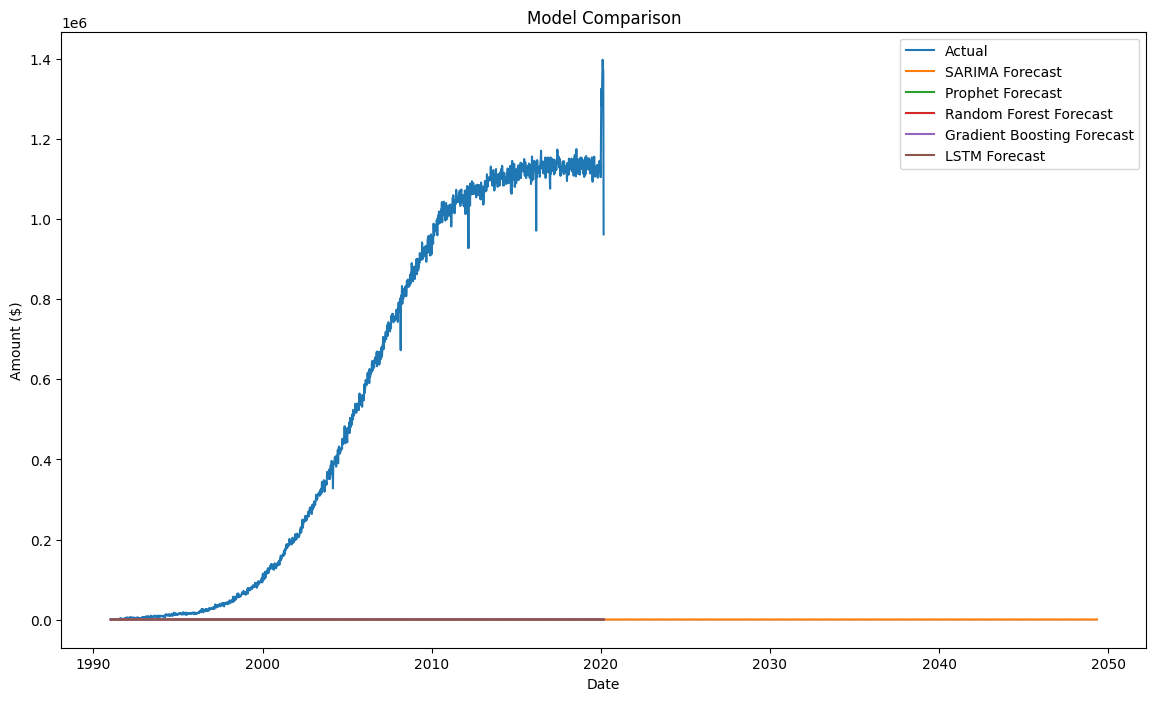

In [83]:
# Evaluation Function
def evaluate_model(predictions, actual):
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = mse ** 0.5
    return mae, mse, rmse

print('Training and test data loaded...')

# Model 1: SARIMA
model_sarima = SARIMAX(train_data['Amount'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = model_sarima.fit(disp=False)
sarima_forecast = sarima_fit.get_forecast(steps=len(test_data))
sarima_pred = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int()

print('SARIMA execution complete...')

# Model 2: Prophet
prophet_data = train_data.reset_index().rename(columns={'Timestamp': 'ds', 'Amount': 'y'})
model_prophet = Prophet()
model_prophet.fit(prophet_data[['ds', 'y']])
future_dates = model_prophet.make_future_dataframe(periods=len(test_data), freq='W')
forecast_prophet = model_prophet.predict(future_dates)
prophet_pred = forecast_prophet['yhat'][-len(test_data):]
print('Prophet execution complete...')

# Model 3: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_data[['WeekOfYear', 'Year']], train_data['Amount'])
rf_pred = rf_model.predict(test_data[['WeekOfYear', 'Year']])
print('Random Forest execution complete...')

# Model 4: Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(train_data[['WeekOfYear', 'Year']], train_data['Amount'])
gb_pred = gb_model.predict(test_data[['WeekOfYear', 'Year']])
print('Gradient Boosting execution complete...')

# Model 5: LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data['Amount'].values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data['Amount'].values.reshape(-1, 1))
print('LSTM execution complete...')

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
trainX, trainY = create_dataset(scaled_train_data, look_back)
testX, testY = create_dataset(scaled_test_data, look_back)

print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("testX shape:", testX.shape)
print("testY shape:", testY.shape)

# Ensure the datasets are not empty and have the correct shape
if trainX.shape[0] == 0 or testX.shape[0] == 0:
    raise ValueError("trainX or testX is empty. Adjust look_back or check data splitting.")

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("Reshaped trainX shape:", trainX.shape)
print("Reshaped testX shape:", testX.shape)

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, look_back)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
lstm_train_predict = lstm_model.predict(trainX)
lstm_test_predict = lstm_model.predict(testX)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)

# Evaluation
sarima_mae, sarima_mse, sarima_rmse = evaluate_model(sarima_pred, test_data['Amount'])
prophet_mae, prophet_mse, prophet_rmse = evaluate_model(prophet_pred, test_data['Amount'])
rf_mae, rf_mse, rf_rmse = evaluate_model(rf_pred, test_data['Amount'])
gb_mae, gb_mse, gb_rmse = evaluate_model(gb_pred, test_data['Amount'])
lstm_mae, lstm_mse, lstm_rmse = evaluate_model(lstm_test_predict, test_data['Amount'][look_back + 1:])

print(f'SARIMA MAE: {sarima_mae}, MSE: {sarima_mse}, RMSE: {sarima_rmse}')
print(f'Prophet MAE: {prophet_mae}, MSE: {prophet_mse}, RMSE: {prophet_rmse}')
print(f'Random Forest MAE: {rf_mae}, MSE: {rf_mse}, RMSE: {rf_rmse}')
print(f'Gradient Boosting MAE: {gb_mae}, MSE: {gb_mse}, RMSE: {gb_rmse}')
print(f'LSTM MAE: {lstm_mae}, MSE: {lstm_mse}, RMSE: {lstm_rmse}')

# Determine the best model based on RMSE
models = {
    'SARIMA': sarima_rmse,
    'Prophet': prophet_rmse,
    'Random Forest': rf_rmse,
    'Gradient Boosting': gb_rmse,
    'LSTM': lstm_rmse
}

best_model_name = min(models, key=models.get)
best_model_rmse = models[best_model_name]

print(f'The best model is {best_model_name} with RMSE: {best_model_rmse}')

# Plot the results
plt.figure(figsize=(14, 8))

plt.plot(test_data.index, test_data['Amount'], label='Actual')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA Forecast')
plt.fill_between(sarima_conf_int.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='k', alpha=.15)
plt.plot(test_data.index, prophet_pred, label='Prophet Forecast')
plt.plot(test_data.index, rf_pred, label='Random Forest Forecast')
plt.plot(test_data.index, gb_pred, label='Gradient Boosting Forecast')
plt.plot(test_data.index[look_back + 1:], lstm_test_predict, label='LSTM Forecast')

plt.title('Model Comparison')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend()
plt.show()


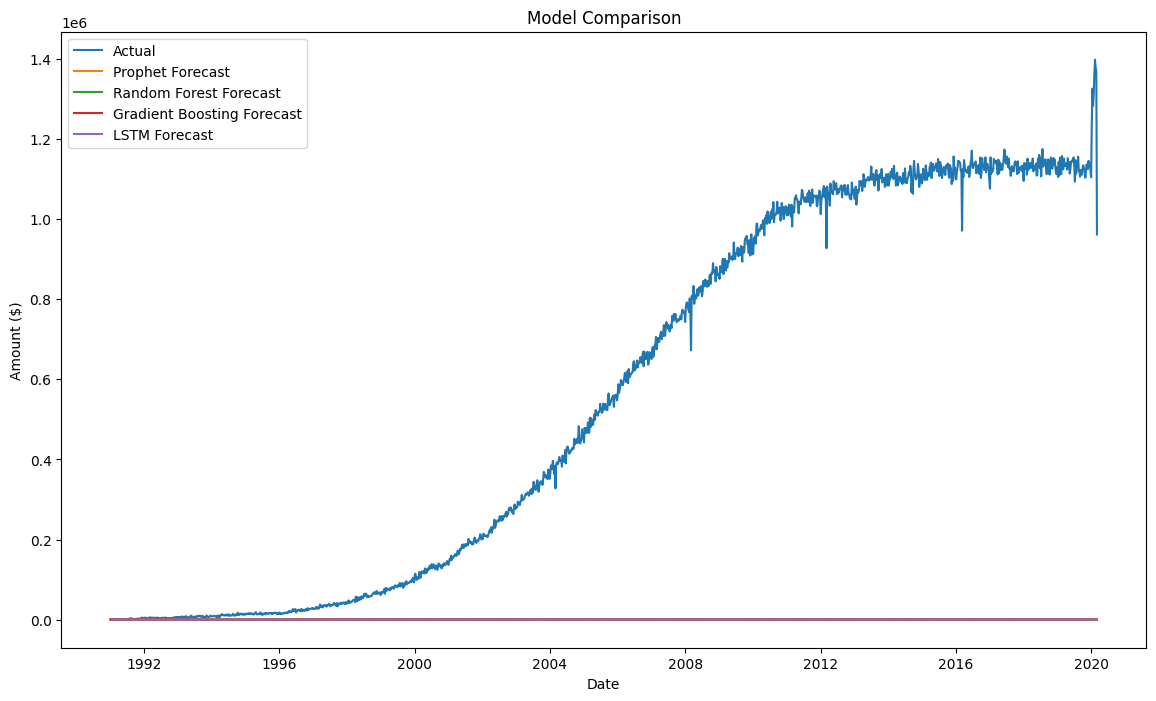

In [84]:
# Plot the results
plt.figure(figsize=(14, 8))

plt.plot(test_data.index, test_data['Amount'], label='Actual')
# plt.plot(sarima_pred.index, sarima_pred, label='SARIMA Forecast')
# plt.fill_between(sarima_conf_int.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='k', alpha=.15)
plt.plot(test_data.index, prophet_pred, label='Prophet Forecast')
plt.plot(test_data.index, rf_pred, label='Random Forest Forecast')
plt.plot(test_data.index, gb_pred, label='Gradient Boosting Forecast')
plt.plot(test_data.index[look_back + 1:], lstm_test_predict, label='LSTM Forecast')

plt.title('Model Comparison')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend()
plt.show()

In [79]:
import pickle

# Save models using pickle
with open('../train_model/models.pkl', 'wb') as f:
    pickle.dump({
        'sarima_model': sarima_fit,
        'prophet_model': model_prophet,
        'random_forest_model': rf_model,
        'gradient_boosting_model': gb_model,
        'lstm_model': lstm_model
    }, f)

print('Models saved using pickle.')

Models saved using pickle.
